#### Why are you doing this? 
* To understand the effect of heterogeniety on network dynamics 

    * Does network become less or more chaotic as a result of heterogeniety? 
    * One way to measure dynamics is to calculate the largest Luyapnov exponent of the network 


TODO:
1. Check why ESNs are performing worse with heterogniety and what is a standard performance 
2.  

In [16]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import math

dir_name = 'heterogeneity_results'

# file_name_ddn = '2024-09-26_single_task_exp_DDN_fixed_decay_per_cluster.p'
# file_name_esn = '2024-09-26_single_task_exp_BL_fixed_decay_per_cluster.p'


# esn_dict = pkl.load(open(dir_name + '/' + file_name_esn, 'rb'))
# ddn_dict = pkl.load(open(dir_name + '/' + file_name_ddn, 'rb'))

file_name_esn_dist_net    = '2024-09-26_single_task_exp_BL_dist_decay_net_wide.p'
file_name_esn_dist_clust  = '2024-09-26_single_task_exp_BL_dist_decay_per_cluster.p'
file_name_esn_fixed_net   = '2024-09-26_single_task_exp_BL_fixed_decay_net_wide.p'
file_name_esn_fixed_clust = '2024-09-26_single_task_exp_BL_fixed_decay_per_cluster.p'
file_name_ddn_fixed_net   = '2024-09-26_single_task_exp_DDN_fixed_decay_net_wide.p'
file_name_ddn_fixed_clust = '2024-09-26_single_task_exp_DDN_fixed_decay_per_cluster.p'
file_name_ddn_dist_net    = '2024-09-26_single_task_exp_DDN_dist_decay_net_wide.p'
file_name_ddn_dist_clust  = '2024-09-26_single_task_exp_DDN_dist_decay_per_cluster.p'


esn_dist_net_dict = pkl.load(open(dir_name + '/' +    file_name_esn_dist_net, 'rb'))
esn_dist_clust_dict = pkl.load(open(dir_name + '/' +  file_name_esn_dist_clust, 'rb'))
esn_fixed_net_dict = pkl.load(open(dir_name + '/' +   file_name_esn_fixed_net, 'rb'))
esn_fixed_clust_dict = pkl.load(open(dir_name + '/' + file_name_esn_fixed_clust, 'rb'))
ddn_fixed_net_dict = pkl.load(open(dir_name + '/' +   file_name_ddn_fixed_net, 'rb'))
ddn_fixed_clust_dict = pkl.load(open(dir_name + '/' + file_name_ddn_fixed_clust, 'rb'))
ddn_dist_net_dict = pkl.load(open(dir_name + '/' +    file_name_ddn_dist_net, 'rb'))
ddn_dist_clust_dict = pkl.load(open(dir_name + '/' +  file_name_ddn_dist_clust, 'rb'))

from tensorflow.python.ops import parallel_for as pfor

import pdb

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
# import tf_utils
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.compat.v1.reset_default_graph() 

def plot_fps(
	state_traj=None,
	plot_batch_idx=None,
	plot_start_time=0,
	plot_stop_time=None,
	mode_scale=0.25,
	fig=None,
	is_lif=False,
	cust_idx = None,
	cust_col = 'g',
	plot_points = True,
	plot_custom = False):

	'''Plots a visualization and analysis of the unique fixed points.

	1) Finds a low-dimensional subspace for visualization via PCA. If
	state_traj is provided, PCA is fit to [all of] those RNN state
	trajectories. Otherwise, PCA is fit to the identified unique fixed
	points. This subspace is 3-dimensional if the RNN state dimensionality
	is >= 3.

	2) Plots the PCA representation of the stable unique fixed points as
	black dots.

	3) Plots the PCA representation of the unstable unique fixed points as
	red dots.

	4) Plots the PCA representation of the modes of the Jacobian at each
	fixed point. By default, only unstable modes are plotted.

	5) (optional) Plots example RNN state trajectories as blue lines.

	Args:
		fps: a FixedPoints object. See FixedPoints.py.

		state_traj (optional): [n_batch x n_time x n_states] numpy
		array or LSTMStateTuple with .c and .h as
		[n_batch x n_time x n_states/2] numpy arrays. Contains example
		trials of RNN state trajectories.

		plot_batch_idx (optional): Indices specifying which trials in
		state_traj to plot on top of the fixed points. Default: plot all
		trials.

		plot_start_time (optional): int specifying the first timestep to
		plot in the example trials of state_traj. Default: 0.

		plot_stop_time (optional): int specifying the last timestep to
		plot in the example trials of stat_traj. Default: n_time.

		stop_time (optional):

		mode_scale (optional): Non-negative float specifying the scaling
		of the plotted eigenmodes. A value of 1.0 results in each mode
		plotted as a set of diametrically opposed line segments
		originating at a fixed point, with each segment's length specified
		by the magnitude of the corresponding eigenvalue.

		fig (optional): Matplotlib figure upon which to plot.

	Returns:
		None.
	'''

	FONT_WEIGHT = 'bold'
	if fig is None:
		FIG_WIDTH = 8 # inches
		FIG_HEIGHT = 8 # inches
		fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),
			tight_layout=True)

	if state_traj is not None:
		if tf_utils.is_lstm(state_traj):
			state_traj_bxtxd = tf_utils.convert_from_LSTMStateTuple(
		state_traj)
		else:
			state_traj_bxtxd = state_traj

		[n_batch, n_time, n_states] = state_traj_bxtxd.shape

		# Ensure plot_start_time >= 0
		plot_start_time = np.max([plot_start_time, 0])

		if plot_stop_time is None:
			plot_stop_time = n_time
		else:
			# Ensure plot_stop_time <= n_time
			plot_stop_time = np.min([plot_stop_time, n_time])

		plot_time_idx = range(plot_start_time, plot_stop_time)

	
	n_states = n_states

	if n_states >= 3:
		pca = PCA(n_components=3)

		if state_traj is not None:
			state_traj_btxd = np.reshape(state_traj_bxtxd,
				(n_batch*n_time, n_states))
			pca.fit(state_traj_btxd)


		ax = fig.add_subplot(111, projection='3d')
		# ax = Axes3D(fig)

		ax.set_xlabel('PC 1', fontweight=FONT_WEIGHT)
		ax.set_zlabel('PC 3', fontweight=FONT_WEIGHT)
		ax.set_ylabel('PC 2', fontweight=FONT_WEIGHT)

		# For generating figure in paper.md
		ax.set_xticks([-2, -1, 0, 1, 2])
		ax.set_yticks([-1, 0, 1])
		ax.set_zticks([-1, 0, 1])
	else:
		# For 1D or 0D networks (i.e., never)
		pca = None
		ax = fig.add_subplot(111)
		ax.xlabel('Hidden 1', fontweight=FONT_WEIGHT)
		if n_states == 2:
			ax.ylabel('Hidden 2', fontweight=FONT_WEIGHT)

	if state_traj is not None:
		if plot_batch_idx is None:
			plot_batch_idx = range(n_batch)

		for batch_idx in plot_batch_idx:
			x_idx = state_traj_bxtxd[batch_idx]

			if n_states >= 3:
				z_idx = pca.transform(x_idx[plot_time_idx, :])
			else:
				z_idx = x_idx[plot_time_idx, :]
			plot_123d(ax, z_idx, color='r', linewidth=0.2)
	


	# for angle in range(0, 360):
	# 	ax.view_init(30, angle)
	# 	plt.draw()
	# 	plt.pause(.001)
	# 	# plt.show()
	plt.ion()
	plt.show()
	plt.pause(1e-10)

def plot_123d(ax, z, **kwargs):
	'''Plots in 1D, 2D, or 3D.

	Args:
		ax: Matplotlib figure axis on which to plot everything.

		z: [n x n_states] numpy array containing data to be plotted,
		where n_states is 1, 2, or 3.

		any keyword arguments that can be passed to ax.plot(...).

	Returns:
		None.
	'''
	n_states = z.shape[1]
	
	if n_states ==3:
		ax.plot(z[:, 0], z[:, 1], z[:, 2], **kwargs)
	elif n_states == 2:
		ax.plot(z[:, 0], z[:, 1], **kwargs)
	elif n_states == 1:
		ax.plot(z, **kwargs)
	return ax

In [17]:
a = np.random.randn(10,10)
b = a.copy()

b[0,:] = b[0,:]+10*(a[0,:]/np.linalg.norm(a[0,:]))


In [18]:
import sys
sys.path.append('C:/Users/Nishant Joshi/Downloads/DDN-public/fixed-point-finder')

In [19]:

sys.path.append('TF_version')
from ESN_cell import * 

In [20]:
# esn_example = esn_dict['example net']
# ddn_example = ddn_dict['example net']


esn_dist_net_dict_example    =  esn_dist_net_dict['example net'] 
esn_dist_clust_dict_example  =  esn_dist_clust_dict['example net'] 
esn_fixed_net_dict_example   =  esn_fixed_net_dict['example net'] 
esn_fixed_clust_dict_example =  esn_fixed_clust_dict['example net'] 
ddn_fixed_net_dict_example   =  ddn_fixed_net_dict['example net'] 
ddn_fixed_clust_dict_example =  ddn_fixed_clust_dict['example net'] 
ddn_dist_net_dict_example    =  ddn_dist_net_dict['example net'] 
ddn_dist_clust_dict_example  =  ddn_dist_clust_dict['example net'] 

In [7]:
def get_validation_throughout_evolution(dict, gen_max, populations=False, multitask=False):
    # Validation scores are saved in a matrix with dimensions:
    # generations x hyperparameter candidates x re-initializations x lag search grid
    if not multitask:
        all_scores = dict['validation performance'][:gen_max, :, :, :]
    else:
        all_scores = dict['validation performance'][:gen_max, :, :, :, :]
    # from the lag search grid we select the best score (lowest NRMSE), since this was the best 
    # performing readout model
    best_lag_scores = np.min(all_scores, axis=-1)
    
    if multitask:
        # from the tasks, we select the average
        # best_lag_scores = best_lag_scores[:, :, :, 0]**2
        best_lag_scores = np.mean(best_lag_scores, axis=-1)
    
    # from the re-initializations from the same hyperparameter set/candidate, we take the average
    best_candidate_scores = np.mean(best_lag_scores, axis=-1)
    
    if populations:
        return best_candidate_scores
    
    # from the population of hyperparameter candidates, we select the best candidate
    best_gen_scores = np.min(best_candidate_scores, axis=-1)
    return best_gen_scores

def get_best_candidate(dict, gen_max, multitask=False):
    best_gen_scores = get_validation_throughout_evolution(dict, gen_max, multitask=multitask)   
    best_candidates = get_validation_throughout_evolution(dict, gen_max, populations=True, multitask=multitask)
    best_gen_ind = np.argmin(best_gen_scores)
    best_candidate_ind = np.argmin(best_candidates[best_gen_ind])
    return best_gen_ind, best_candidate_ind
    
def sample_best_net(dict, n, gen_max, multitask=False):
    gen, ind = get_best_candidate(dict, gen_max, multitask=multitask)
    print(gen, ind)
    start_net = dict['example net']
    best_parameter_set = dict['parameters'][gen, ind, :]
    best_nets = []
    for i in range(n):
        best_net = start_net.get_new_network_from_serialized(best_parameter_set)
        best_nets.append(best_net)
    return best_nets


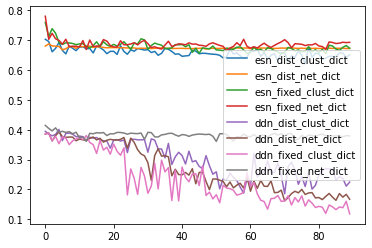

In [8]:

gen_max = 90
# val_scores_ddn = get_validation_throughout_evolution(ddn_dict, gen_max, multitask=False)
# val_scores_esn = get_validation_throughout_evolution(esn_dict, gen_max, multitask=False)


val_scores_esn_dist_clust_dict =  get_validation_throughout_evolution(esn_dist_clust_dict   , gen_max, multitask=False)
val_scores_esn_dist_net_dict =    get_validation_throughout_evolution(esn_dist_net_dict , gen_max, multitask=False)
val_scores_esn_fixed_clust_dict = get_validation_throughout_evolution(esn_fixed_clust_dict   , gen_max, multitask=False)
val_scores_esn_fixed_net_dict =   get_validation_throughout_evolution(esn_fixed_net_dict   , gen_max, multitask=False)
val_scores_ddn_dist_clust_dict =  get_validation_throughout_evolution(ddn_dist_clust_dict   , gen_max, multitask=False)
val_scores_ddn_dist_net_dict =    get_validation_throughout_evolution(ddn_dist_net_dict   , gen_max, multitask=False)
val_scores_ddn_fixed_clust_dict = get_validation_throughout_evolution(ddn_fixed_clust_dict   , gen_max, multitask=False)
val_scores_ddn_fixed_net_dict =   get_validation_throughout_evolution(ddn_fixed_net_dict   , gen_max, multitask=False)

# plt.plot(val_scores_ddn,label ='ddn')
# plt.plot(val_scores_esn,label ='esn')

plt.plot(val_scores_esn_dist_clust_dict, label = 'esn_dist_clust_dict')
plt.plot(val_scores_esn_dist_net_dict, label = 'esn_dist_net_dict')
plt.plot(val_scores_esn_fixed_clust_dict, label = 'esn_fixed_clust_dict')
plt.plot(val_scores_esn_fixed_net_dict, label = 'esn_fixed_net_dict')
plt.plot(val_scores_ddn_dist_clust_dict, label = 'ddn_dist_clust_dict')
plt.plot(val_scores_ddn_dist_net_dict, label = 'ddn_dist_net_dict')
plt.plot(val_scores_ddn_fixed_clust_dict, label = 'ddn_fixed_clust_dict')
plt.plot(val_scores_ddn_fixed_net_dict, label = 'ddn_fixed_net_dict')

plt.legend()
plt.show()

In [9]:
nr_of_nets = 10
best_nets_esns_dist_clust_dict =  sample_best_net(esn_dist_net_dict, nr_of_nets, gen_max, multitask=False)
best_nets_esns_dist_net_dict =    sample_best_net(esn_dist_clust_dict, nr_of_nets, gen_max, multitask=False)
best_nets_esns_fixed_clust_dict = sample_best_net(esn_fixed_net_dict, nr_of_nets, gen_max, multitask=False)
best_nets_esns_fixed_net_dict =   sample_best_net(esn_fixed_clust_dict, nr_of_nets, gen_max, multitask=False)
best_nets_ddns_dist_clust_dict =  sample_best_net(ddn_fixed_net_dict, nr_of_nets, gen_max, multitask=False)
best_nets_ddns_dist_net_dict =    sample_best_net(ddn_fixed_clust_dict, nr_of_nets, gen_max, multitask=False)
best_nets_ddns_fixed_clust_dict = sample_best_net(ddn_dist_net_dict, nr_of_nets, gen_max, multitask=False)
best_nets_ddns_fixed_net_dict =   sample_best_net(ddn_dist_clust_dict, nr_of_nets, gen_max, multitask=False)


5 15
76 6
53 8
69 14
50 10
89 13
70 1
70 16


## Dynamics

In [10]:
def paste_best_vars_on_nets(net):
    vars_to_copy = ['W',
                    'WBias',
                    'n_type',
                    'coordinates',
                    'decay',
                    'neurons_in',
                    'neurons_out',
                    'activation_func',
                    'dt',
                    'theta_window',
                    'theta_y0',
                    'lr',
                    'var_delays',]

    trial_ESN = ESNCell_S(weights =vars(net)['W'] ,
                      bias =vars(net)['WBias'] ,
                      n_type =vars(net)['n_type'], 
                      coordinates =vars(net)['coordinates'], 
                      decay =vars(net)['decay'] ,
                      input_n =vars(net)['neurons_in'], 
                      output_n =vars(net)['neurons_out'], 
                      activation_func =vars(net)['activation_func'], 
                      dt =vars(net)['dt'] ,
                      theta_window =vars(net)['theta_window'] ,
                      theta_y0 =vars(net)['theta_y0'] ,
                      lr =vars(net)['lr'] ,
                      var_delays =vars(net)['var_delays'] )    
    return trial_ESN

# ENS_ready1 = paste_best_vars_on_nets(best_nets_esns[0])
# ENS_ready2 = paste_best_vars_on_nets(best_nets_esns[0])

ENS_ready_esns_dist_clust_dict1  = paste_best_vars_on_nets(best_nets_esns_dist_clust_dict[0])
ENS_ready_esns_dist_net_dict1    = paste_best_vars_on_nets(best_nets_esns_dist_net_dict[0])
ENS_ready_esns_fixed_clust_dict1 = paste_best_vars_on_nets(best_nets_esns_fixed_clust_dict[0])
ENS_ready_esns_fixed_net_dict1   = paste_best_vars_on_nets(best_nets_esns_fixed_net_dict[0])
ENS_ready_ddns_dist_clust_dict1  = paste_best_vars_on_nets(best_nets_ddns_dist_clust_dict[0])
ENS_ready_ddns_dist_net_dict1    = paste_best_vars_on_nets(best_nets_ddns_dist_net_dict[0])
ENS_ready_ddns_fixed_clust_dict1 = paste_best_vars_on_nets(best_nets_ddns_fixed_clust_dict[0])
ENS_ready_ddns_fixed_net_dict1   = paste_best_vars_on_nets(best_nets_ddns_fixed_net_dict[0]) 


ENS_ready_esns_dist_clust_dict2  = paste_best_vars_on_nets(best_nets_esns_dist_clust_dict[0])
ENS_ready_esns_dist_net_dict2    = paste_best_vars_on_nets(best_nets_esns_dist_net_dict[0])
ENS_ready_esns_fixed_clust_dict2 = paste_best_vars_on_nets(best_nets_esns_fixed_clust_dict[0])
ENS_ready_esns_fixed_net_dict2   = paste_best_vars_on_nets(best_nets_esns_fixed_net_dict[0])
ENS_ready_ddns_dist_clust_dict2  = paste_best_vars_on_nets(best_nets_ddns_dist_clust_dict[0])
ENS_ready_ddns_dist_net_dict2    = paste_best_vars_on_nets(best_nets_ddns_dist_net_dict[0])
ENS_ready_ddns_fixed_clust_dict2 = paste_best_vars_on_nets(best_nets_ddns_fixed_clust_dict[0])
ENS_ready_ddns_fixed_net_dict2   = paste_best_vars_on_nets(best_nets_ddns_fixed_net_dict[0]) 

In [11]:
# ENS_ready1.activation_func  = sigmoid_activation_tf
# ENS_ready2.activation_func  = sigmoid_activation_tf


ENS_ready_esns_dist_clust_dict1.activation_func = sigmoid_activation_tf
ENS_ready_esns_dist_net_dict1.activation_func = sigmoid_activation_tf
ENS_ready_esns_fixed_clust_dict1.activation_func = sigmoid_activation_tf
ENS_ready_esns_fixed_net_dict1.activation_func = sigmoid_activation_tf
ENS_ready_ddns_dist_clust_dict1.activation_func = sigmoid_activation_tf
ENS_ready_ddns_dist_net_dict1.activation_func = sigmoid_activation_tf
ENS_ready_ddns_fixed_clust_dict1.activation_func = sigmoid_activation_tf
ENS_ready_ddns_fixed_net_dict1.activation_func = sigmoid_activation_tf

ENS_ready_esns_dist_clust_dict2.activation_func = sigmoid_activation_tf
ENS_ready_esns_dist_net_dict2.activation_func = sigmoid_activation_tf
ENS_ready_esns_fixed_clust_dict2.activation_func = sigmoid_activation_tf
ENS_ready_esns_fixed_net_dict2.activation_func = sigmoid_activation_tf
ENS_ready_ddns_dist_clust_dict2.activation_func = sigmoid_activation_tf
ENS_ready_ddns_dist_net_dict2.activation_func = sigmoid_activation_tf
ENS_ready_ddns_fixed_clust_dict2.activation_func = sigmoid_activation_tf
ENS_ready_ddns_fixed_net_dict2.activation_func = sigmoid_activation_tf


### TEST THE CELL

In [29]:
# INPUT = np.random.normal(0, 0.5, size=(1,100))
# tf.compat.v1.disable_eager_execution()


# # tf.compat.v1.enable_eager_execution()

# tf.compat.v1.reset_default_graph()

# # tf.compat.v1.disable_v2_behavior() 
# # esn_model = Model(input_data = np.random.normal(0, 0.5, size=(1,100)))

# with  tf.compat.v1.Session() as sess:
#     x = tf.compat.v1.placeholder(tf.float32, [1, 100], name='input_placeholder')

#     esn_model = Model(cell=ENS_ready,input_data = x)

#     sess.run(tf.compat.v1.global_variables_initializer())
#     h = sess.run([esn_model.net_states],
                        #   feed_dict={x:INPUT})

In [12]:
from utils import createNARMA30

narma_input,narma_output = createNARMA30(1000)

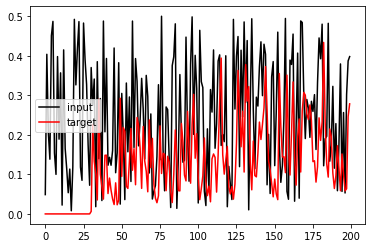

In [31]:
plt.plot(narma_input[:200],c='black',label = 'input')
plt.plot(narma_output[:200],c='red',label = 'target')
plt.legend()

## Luyapnov Stuff 

ESN and Chaos https://lizier.me/joseph/publications/2010-Boedecker-InfoProcessingEchoStateNets.pdf 

How to calcualte Luyapnov Spectra https://fy.chalmers.se/~f99krgu/dynsys/DynSysLecture10.pdf#page=1.11

https://arxiv.org/pdf/2006.02427#page=17.26 Important Luyapnov results

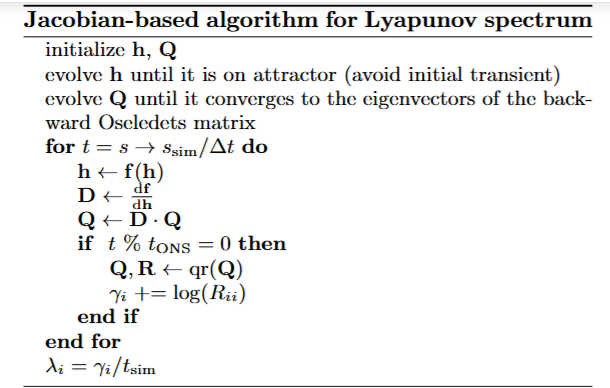

https://www.sciencedirect.com/science/article/pii/S0370157319302601#sec2 How to calculate jacobian of a delay differential equation 

In [13]:
from tqdm  import tqdm 
from tensorflow.python.ops.parallel_for.gradients import jacobian

def oneStepVarQR(J, Q):
    Z = tf.compat.v1.matmul(J, Q)
    q, r = tf.linalg.qr(Z, full_matrices=False)
    s = tf.linalg.diag(tf.sign(tf.linalg.diag_part(r)))
    return tf.compat.v1.matmul(q, s), tf.linalg.diag_part(tf.matmul(s, r))

# @tf.function
def calc_jac(*params, model):
	if len(params)>2:
		inputs, states, sess = params #inputs should be a single time step with batch_size entries

	else:
		inputs, states = params #inputs should be a single time step with batch_size entries

	L = model.cell.neurons_out.shape[0]

    #Feed forward into network
	N, delay = states.shape 

	with tf.GradientTape() as tape:
		model_out, F =  model.cell.call(inputs, states)
		J_tf = tape.jacobian(F[:,0], states)

	return tf.reshape(J_tf,(N,N*delay))[:N-1,:(N-1)*delay]

# @tf.function
def build_vars( init_states ):
	n_state,n_delay = init_states.shape
	init_states = np.concatenate([init_states,np.zeros((1,n_delay))],axis=0)
	x = tf.Variable(init_states,dtype=tf.float32)
	x_rnn_cell = x

	return x,x_rnn_cell

def calc_LEs_an(*params, model, k_LE=100000, rec_layer= 0, kappa = 10, diff= 10, warmup = 10, T_ons = 1):
	if len(params)>2:
		x_in = params[0]
		hc = params[1]
		sess = params[2]
	else:
		x_in = params[0]
		hc = params[1]

	h0,_ = build_vars(hc)
	hidden_size, delay = h0.shape
	input_size , feed_seq = x_in.shape
	L = model.cell.neurons_out.shape[0] #*delay
		
	k_LE = max(min(L, k_LE), 1)
	Q = tf.reshape(tf.eye(L*delay), (L, L*delay))
	Q = Q[ :, :k_LE*delay] #Choose how many exponents to track

	ht = h0    
	
	
	rvals = [] #tf.Variable(tf.ones((feed_seq, k_LE)))#storage
	qvect = [] #tf.Variable(tf.zeros((feed_seq, L, k_LE)) )#storage
	Js    = [] #tf.Variable(tf.zeros((feed_seq, L+1, L+1, delay)) )#storage
	t = 0
	J_first = None
	#Warmup
	for xt in x_in[0,:warmup]:

		states = ht
		
		J = calc_jac(tf.cast(np.array([xt]), dtype = 'float32'), states, sess, model=model)
		_, states = model.cell.call(tf.cast(np.array([xt]),dtype = 'float32'), states)

		ht = states
		Q = tf.matmul(J, Q)
	Q, _ = tf.compat.v1.qr(Q)
	#     print(Q.shape)
	
	# T_pred = np.log(kappa/diff)
	# T_ons = max(1, math.floor(T_pred))
	# print('Pred = {}, QR Interval: {}'.format(T_pred, T_ons))

	hts  = []
	t_QR = t
	for xt in x_in[0,warmup:]:
		if (t - t_QR) >= T_ons or t==0 or t == feed_seq:
			QR = True
		else: 
			QR = True

		states = ht
		

		J = calc_jac(tf.cast(np.array([xt]),dtype = 'float32'), states, sess, model=model)

		if t == 0:
			J_first = J

		_, states = model.cell.call(tf.cast(np.array([xt]),dtype = 'float32'), states) #run one step 
		
		if QR:
			Q, r = oneStepVarQR(J, Q)
			t_QR = t
			
		else:
			Q = tf.matmul(J, Q)
			r = tf.ones((1, hidden_size*delay))

		ht = states
		
		# rvals = tf.compat.v1.assign(rvals[t, :, ], r)
		# qvect = tf.compat.v1.assign(qvect[t, :, :] , Q)
		# Js    = tf.compat.v1.assign(Js[t, :, :, :] , J)

		rvals.append(r)
		qvect.append(Q)
		Js.append(J)
		hts.append(ht)
		t = t+1

		
	LEs = tf.reduce_sum(tf.experimental.numpy.log(rvals), axis = 0)/feed_seq
	
	#     print(torch.log2(rvals.detach()).shape)
	return LEs, rvals , qvect, Js, hts, J_first

def plot_evolution(rvals, k_LE, model_name = '', sample_id = 0, title = False, plot_size = (10, 7)):
    plt.figure(figsize = plot_size)
    feed_seq = rvals.shape[1]
    if type(k_LE == int):
        for i in range(k_LE):
            f = plt.plot(np.divide(np.cumsum(np.log2(rvals[i,:]),),np.arange(1., feed_seq+1)))
    else:
        f = plt.plot(np.divide(np.cumsum(np.log2(rvals[i,:]),),np.arange(1., feed_seq+1)))
    f = plt.xlabel('Iteration #')
    f = plt.ylabel('Lyapunov Exponent')
    if title:
        plt.title('LE Spectrum Evolution for '+model_name+', Sample #'+ str(sample_id))
    return f

## Find Fixed Points

In [14]:
def renormalize(gamma_0, state1, state2, norm_order = 2,count  = 0):
    diff_k = state2- state1
    # if tf.linalg.norm(diff_k[:,0])> 0:
    state2 = tf.compat.v1.assign(state2[:,0], state1[:,0]+ gamma_0*(state2[:,0]/tf.linalg.norm(state2[:,0]))) 

    # elif tf.linalg.norm(diff_k[:,0])==0:
    #     state2 = tf.compat.v1.assign(state2, state1+ (gamma_0/tf.linalg.norm(diff_k[:,0])*(diff_k)))
    return [state1, state2] 

@tf.function
def luyapnov_exponents(model1, model2, input, every_k = 1, ord =2,trans=15, threshold_prec = 1e-9, N=10):

    state1 = model1.cell.A
    state2 = model2.cell.A

    traj_ref = [] 
    traj_pert = [] 

    traj_ref.append(state1)
    traj_pert.append(state2)
    exps = []
    gamma0 = tf.linalg.norm(state1[:,0] - state2[:,0])
    
    d_lower = threshold_prec*gamma0
    d_upper =  round(1/threshold_prec)*gamma0 
    norm_diff = []
    diff_k = []
    for i in range(input.shape[1]):
        state1,_ = model1.cell.call(input[:,i], traj_ref[-1])
        state2,_ = model2.cell.call(input[:,i], traj_pert[-1])
        dist = state1[:,0] - state2[:,0]        
        diff_k.append(tf.linalg.norm(dist))

        if i>trans:
            # Check if distance is within bounds
            response  = tf.cond((tf.greater(tf.norm(dist), d_upper) or tf.less_equal(tf.norm(dist), d_lower)), lambda: renormalize(gamma0, state2, state1, norm_order=ord,count=i), lambda: [state1, state2])
            state1  = tf.compat.v1.assign(state1,response[0])
            state2  = tf.compat.v1.assign(state2,response[1])
            if len(response)>2:
                norm_diff.append(response[2])
            dist = state1 - state2
            # Renormalize states
            # state1, state2  = renormalize(traj_ref[0] - traj_pert[0], state2, state1, norm_order=ord)
            # # Calculate Lyapunov exponent
        if i%every_k==0:
            exps.append((1/every_k)*tf.math.log(tf.norm(dist) / gamma0))


        traj_ref.append(state1)
        traj_pert.append(state2)

    # exp = [tf.math.log(tf.linalg.norm(j-i, ord=ord)/gamma0) for i,j in zip(traj_ref , traj_pert)]
    # diff = [tf.reduce_mean(i-j) for i,j in zip(traj_ref , traj_pert)]
    return exps , diff_k, traj_ref, traj_pert ,gamma0

In [53]:
def perturb_net(esn_model1, esn_model2, x=None, i=None, pert=None):
    state_zero =  np.zeros_like(esn_model1.cell.A_init)
    rand_state = np.random.randn(*state_zero[:,0].shape)
    state_zero[i,0] += pert

    init_state = esn_model1.cell.A_init
    init_state_delta = esn_model1.cell.A_init + state_zero


    state1 = init_state
    state2 = init_state_delta

    esn_model1.cell.A_init = state1
    esn_model2.cell.A_init = state2

    esn_model1.cell.build(inputs_shape = x.shape[0])
    esn_model2.cell.build(inputs_shape = x.shape[0])
    return esn_model1, esn_model2

In [15]:
from FixedPointSearch_leaky import * 
from FixedPointStore_leaky import * 
from tensorflow.python.ops.parallel_for.gradients import jacobian

input_size = 100

INPUT = np.random.normal(0, 0.5, size=(1,input_size))
narma_input,narma_output = createNARMA30(input_size)
INPUT = narma_input.T
INPUT[:,:] = INPUT[:,:]

tf.compat.v1.disable_eager_execution()

# tf.compat.v1.enable_eager_execution()
# tf.compat.v1.disable_v2_behavior() 
# +np.random.uniform(size=list(h[0][-1,:,:].shape))

pert = 1e-9
threshold = pert*1e-2
max_exps_esns_dist_clust,  ref_trajs_esns_dist_clust, pert_trajs_esns_dist_clust  =   [], [], []
max_exps_esns_dist_net,    ref_trajs_esns_dist_net,   pert_trajs_esns_dist_net    =   [], [], []
max_exps_esns_fixed_clust, ref_trajs_esns_fixed_clust,pert_trajs_esns_fixed_clust =   [], [], []
max_exps_esns_fixed_net,   ref_trajs_esns_fixed_net,  pert_trajs_esns_fixed_net   =   [], [], []
max_exps_ddns_dist_clust,  ref_trajs_ddns_dist_clust, pert_trajs_ddns_dist_clust  =   [], [], []
max_exps_ddns_dist_net,    ref_trajs_ddns_dist_net,   pert_trajs_ddns_dist_net    =   [], [], []
max_exps_ddns_fixed_clust, ref_trajs_ddns_fixed_clust,pert_trajs_ddns_fixed_clust =   [], [], []
max_exps_ddns_fixed_net,   ref_trajs_ddns_fixed_net,  pert_trajs_ddns_fixed_net   =   [], [], []

for i in range(1):
        reset_graph()
        with  tf.compat.v1.Session() as sess:
                x = tf.compat.v1.placeholder(tf.float32, [1, input_size], name='input_placeholder')

                esn_model_esns_dist_clust_dict1 =  Model(cell = ENS_ready_esns_dist_clust_dict1,  input_data = x)
                # esn_model_esns_dist_net_dict1 =    Model(cell = ENS_ready_esns_dist_net_dict1,    input_data = x)
                # esn_model_esns_fixed_clust_dict1 = Model(cell = ENS_ready_esns_fixed_clust_dict1, input_data = x)
                # esn_model_esns_fixed_net_dict1 =   Model(cell = ENS_ready_esns_fixed_net_dict1,   input_data = x)
                # esn_model_ddns_dist_clust_dict1 =  Model(cell = ENS_ready_ddns_dist_clust_dict1,  input_data = x)
                # esn_model_ddns_dist_net_dict1 =    Model(cell = ENS_ready_ddns_dist_net_dict1,    input_data = x)
                # esn_model_ddns_fixed_clust_dict1 = Model(cell = ENS_ready_ddns_fixed_clust_dict1, input_data = x)
                # esn_model_ddns_fixed_net_dict1 =   Model(cell = ENS_ready_ddns_fixed_net_dict1,   input_data = x)


                esn_model_esns_dist_clust_dict2 =  Model(cell = ENS_ready_esns_dist_clust_dict2,  input_data = x)
                # esn_model_esns_dist_net_dict2 =    Model(cell = ENS_ready_esns_dist_net_dict2,    input_data = x)
                # esn_model_esns_fixed_clust_dict2 = Model(cell = ENS_ready_esns_fixed_clust_dict2, input_data = x)
                # esn_model_esns_fixed_net_dict2 =   Model(cell = ENS_ready_esns_fixed_net_dict2,   input_data = x)
                # esn_model_ddns_dist_clust_dict2 =  Model(cell = ENS_ready_ddns_dist_clust_dict2,  input_data = x)
                # esn_model_ddns_dist_net_dict2 =    Model(cell = ENS_ready_ddns_dist_net_dict2,    input_data = x)
                # esn_model_ddns_fixed_clust_dict2 = Model(cell = ENS_ready_ddns_fixed_clust_dict2, input_data = x)
                # esn_model_ddns_fixed_net_dict2 =   Model(cell = ENS_ready_ddns_fixed_net_dict2,   input_data = x)

                esn_model_esns_dist_clust_dict1,  esn_model_esns_dist_clust_dict2  = perturb_net(esn_model_esns_dist_clust_dict1, esn_model_esns_dist_clust_dict2,  x=x, pert = pert, i=i)
                # esn_model_esns_dist_net_dict1,    esn_model_esns_dist_net_dict2    = perturb_net(esn_model_esns_dist_net_dict1,   esn_model_esns_dist_net_dict2,    x=x, pert = pert, i=i)
                # esn_model_esns_fixed_clust_dict1, esn_model_esns_fixed_clust_dict2 = perturb_net(esn_model_esns_fixed_clust_dict1,esn_model_esns_fixed_clust_dict2, x=x, pert = pert, i=i)
                # esn_model_esns_fixed_net_dict1,   esn_model_esns_fixed_net_dict2   = perturb_net(esn_model_esns_fixed_net_dict1,  esn_model_esns_fixed_net_dict2,   x=x, pert = pert, i=i)
                # esn_model_ddns_dist_clust_dict1,  esn_model_ddns_dist_clust_dict2  = perturb_net(esn_model_ddns_dist_clust_dict1, esn_model_ddns_dist_clust_dict2,  x=x, pert = pert, i=i)
                # esn_model_ddns_dist_net_dict1,    esn_model_ddns_dist_net_dict2    = perturb_net(esn_model_ddns_dist_net_dict1,   esn_model_ddns_dist_net_dict2,    x=x, pert = pert, i=i)
                # esn_model_ddns_fixed_clust_dict1, esn_model_ddns_fixed_clust_dict2 = perturb_net(esn_model_ddns_fixed_clust_dict1,esn_model_ddns_fixed_clust_dict2, x=x, pert = pert, i=i)
                # esn_model_ddns_fixed_net_dict1,   esn_model_ddns_fixed_net_dict2   = perturb_net(esn_model_ddns_fixed_net_dict1,  esn_model_ddns_fixed_net_dict2,   x=x, pert = pert, i=i)



                exp_esns_dist_clust_dict, diff_esns_k_dist_clust_dict, traj_ref_esns_dist_clust_dict, traj_pert_esns_dist_clust_dict,gamma0  = luyapnov_exponents(esn_model_esns_dist_clust_dict1,  esn_model_esns_dist_clust_dict2,  input=x,threshold_prec=threshold,every_k=12,trans=25,N=i, ord='fro')
                # exp_esns_dist_net_dict,   diff_esns_k_dist_net_dict,   traj_ref_esns_dist_net_dict,   traj_pert_esns_dist_net_dict    = luyapnov_exponents(esn_model_esns_dist_net_dict1,    esn_model_esns_dist_net_dict2,    input=x,threshold_prec=threshold,every_k=12,trans=25,N=i, ord='fro')
                # exp_esns_fixed_clust_dict,diff_esns_k_fixed_clust_dict,traj_ref_esns_fixed_clust_dict,traj_pert_esns_fixed_clust_dict = luyapnov_exponents(esn_model_esns_fixed_clust_dict1, esn_model_esns_fixed_clust_dict2, input=x,threshold_prec=threshold,every_k=12,trans=25,N=i, ord='fro')
                # exp_esns_fixed_net_dict,  diff_esns_k_fixed_net_dict,  traj_ref_esns_fixed_net_dict,  traj_pert_esns_fixed_net_dict   = luyapnov_exponents(esn_model_esns_fixed_net_dict1,   esn_model_esns_fixed_net_dict2,   input=x,threshold_prec=threshold,every_k=12,trans=25,N=i, ord='fro')
                # exp_ddns_dist_clust_dict, diff_ddns_k_dist_clust_dict, traj_ref_ddns_dist_clust_dict, traj_pert_ddns_dist_clust_dict  = luyapnov_exponents(esn_model_ddns_dist_clust_dict1,  esn_model_ddns_dist_clust_dict2,  input=x,threshold_prec=threshold,every_k=12,trans=25,N=i, ord='fro')
                # exp_ddns_dist_net_dict,   diff_ddns_k_dist_net_dict,   traj_ref_ddns_dist_net_dict,   traj_pert_ddns_dist_net_dict    = luyapnov_exponents(esn_model_ddns_dist_net_dict1,    esn_model_ddns_dist_net_dict2,    input=x,threshold_prec=threshold,every_k=12,trans=25,N=i, ord='fro')
                # exp_ddns_fixed_clust_dict,diff_ddns_k_fixed_clust_dict,traj_ref_ddns_fixed_clust_dict,traj_pert_ddns_fixed_clust_dict = luyapnov_exponents(esn_model_ddns_fixed_clust_dict1, esn_model_ddns_fixed_clust_dict2, input=x,threshold_prec=threshold,every_k=12,trans=25,N=i, ord='fro')
                # exp_ddns_fixed_net_dict,  diff_ddns_k_fixed_net_dict,  traj_ref_ddns_fixed_net_dict,  traj_pert_ddns_fixed_net_dict   = luyapnov_exponents(esn_model_ddns_fixed_net_dict1,   esn_model_ddns_fixed_net_dict2,   input=x,threshold_prec=threshold,every_k=12,trans=25,N=i, ord='fro')


                sess.run(tf.compat.v1.global_variables_initializer())

                exp_esns_dist_clust_dict, diff_esns_k_dist_clust_dict,  traj_ref_esns_dist_clust_dict,  traj_pert_esns_dist_clust_dict, gamma0    = sess.run([exp_esns_dist_clust_dict, diff_esns_k_dist_clust_dict, traj_ref_esns_dist_clust_dict, traj_pert_esns_dist_clust_dict,gamma0 ], feed_dict = {x:INPUT})
                # exp_esns_dist_net_dict,   diff_esns_k_dist_net_dict,    traj_ref_esns_dist_net_dict,    traj_pert_esns_dist_net_dict      = sess.run([exp_esns_dist_net_dict,   diff_esns_k_dist_net_dict,   traj_ref_esns_dist_net_dict,   traj_pert_esns_dist_net_dict ],   feed_dict = {x:INPUT})
                # exp_esns_fixed_clust_dict,diff_esns_k_fixed_clust_dict, traj_ref_esns_fixed_clust_dict, traj_pert_esns_fixed_clust_dict   = sess.run([exp_esns_fixed_clust_dict,diff_esns_k_fixed_clust_dict,traj_ref_esns_fixed_clust_dict,traj_pert_esns_fixed_clust_dict ],feed_dict = {x:INPUT})
                # exp_esns_fixed_net_dict,  diff_esns_k_fixed_net_dict,   traj_ref_esns_fixed_net_dict,   traj_pert_esns_fixed_net_dict     = sess.run([exp_esns_fixed_net_dict,  diff_esns_k_fixed_net_dict,  traj_ref_esns_fixed_net_dict,  traj_pert_esns_fixed_net_dict ],  feed_dict = {x:INPUT})
                # exp_ddns_dist_clust_dict, diff_ddns_k_dist_clust_dict,  traj_ref_ddns_dist_clust_dict,  traj_pert_ddns_dist_clust_dict    = sess.run([exp_ddns_dist_clust_dict, diff_ddns_k_dist_clust_dict, traj_ref_ddns_dist_clust_dict, traj_pert_ddns_dist_clust_dict ], feed_dict = {x:INPUT})
                # exp_ddns_dist_net_dict,   diff_ddns_k_dist_net_dict,    traj_ref_ddns_dist_net_dict,    traj_pert_ddns_dist_net_dict      = sess.run([exp_ddns_dist_net_dict,   diff_ddns_k_dist_net_dict,   traj_ref_ddns_dist_net_dict,   traj_pert_ddns_dist_net_dict ],   feed_dict = {x:INPUT})
                # exp_ddns_fixed_clust_dict,diff_ddns_k_fixed_clust_dict, traj_ref_ddns_fixed_clust_dict, traj_pert_ddns_fixed_clust_dict   = sess.run([exp_ddns_fixed_clust_dict,diff_ddns_k_fixed_clust_dict,traj_ref_ddns_fixed_clust_dict,traj_pert_ddns_fixed_clust_dict ],feed_dict = {x:INPUT})
                # exp_ddns_fixed_net_dict,  diff_ddns_k_fixed_net_dict,   traj_ref_ddns_fixed_net_dict,   traj_pert_ddns_fixed_net_dict     = sess.run([exp_ddns_fixed_net_dict,  diff_ddns_k_fixed_net_dict,  traj_ref_ddns_fixed_net_dict,  traj_pert_ddns_fixed_net_dict ],  feed_dict = {x:INPUT})


                max_exps_esns_dist_clust.append(np.nanmean(exp_esns_dist_clust_dict)),  ref_trajs_esns_dist_clust.append(np.nanmean(traj_ref_esns_dist_clust_dict)),  pert_trajs_esns_dist_clust.append(np.nanmean(traj_pert_esns_dist_clust_dict))
                # max_exps_esns_dist_net.append(np.nanmean(exp_esns_dist_net_dict)),      ref_trajs_esns_dist_net.append(np.nanmean(traj_ref_esns_dist_net_dict)),      pert_trajs_esns_dist_net.append(np.nanmean(traj_pert_esns_dist_net_dict))
                # max_exps_esns_fixed_clust.append(np.nanmean(exp_esns_fixed_clust_dict)),ref_trajs_esns_fixed_clust.append(np.nanmean(traj_ref_esns_fixed_clust_dict)),pert_trajs_esns_fixed_clust.append(np.nanmean(traj_pert_esns_fixed_clust_dict))
                # max_exps_esns_fixed_net.append(np.nanmean(exp_esns_fixed_net_dict)),    ref_trajs_esns_fixed_net.append(np.nanmean(traj_ref_esns_fixed_net_dict)),    pert_trajs_esns_fixed_net.append(np.nanmean(traj_pert_esns_fixed_net_dict))
                # max_exps_ddns_dist_clust.append(np.nanmean(exp_ddns_dist_clust_dict)),  ref_trajs_ddns_dist_clust.append(np.nanmean(traj_ref_ddns_dist_clust_dict)),  pert_trajs_ddns_dist_clust.append(np.nanmean(traj_pert_ddns_dist_clust_dict))
                # max_exps_ddns_dist_net.append(np.nanmean(exp_ddns_dist_net_dict)),      ref_trajs_ddns_dist_net.append(np.nanmean(traj_ref_ddns_dist_net_dict)),      pert_trajs_ddns_dist_net.append(np.nanmean(traj_pert_ddns_dist_net_dict))
                # max_exps_ddns_fixed_clust.append(np.nanmean(exp_ddns_fixed_clust_dict)),ref_trajs_ddns_fixed_clust.append(np.nanmean(traj_ref_ddns_fixed_clust_dict)),pert_trajs_ddns_fixed_clust.append(np.nanmean(traj_pert_ddns_fixed_clust_dict))
                # max_exps_ddns_fixed_net.append(np.nanmean(exp_ddns_fixed_net_dict)),    ref_trajs_ddns_fixed_net.append(np.nanmean(traj_ref_ddns_fixed_net_dict)),    pert_trajs_ddns_fixed_net.append(np.nanmean(traj_pert_ddns_fixed_net_dict))

                # max_exps.append(np.nanmean(exp))
                # ref_trajs.append(traj_ref)
                # pert_trajs.append(traj_pert)


                # LEs, rvals, qvect, Js, hts,J_first = calc_LEs_an(INPUT, h[0][-2,:,:], sess, model = esn_model,T_ons = 20)
                # sess.run(tf.compat.v1.global_variables_initializer())
                # LEs_, rvals_, qvect_, Js_,hts_, J_first = sess.run([LEs,rvals,qvect,Js,hts,J_first],feed_dict={x:INPUT})

                # fps = FixedPointSearch(
                #         ctype = 'ESN',
                #         states = h[0][500:,:,:],
                #         savepath = '/content', 
                #         cell=esn_model.cell,
                #         sess = sess,
                #         opt_type= 'joint',
                #         super_verbose = True,
                #         adaptive_learning_rate_hps  = {'initial_rate':0.01})

                # sample = 0.0
                # sample_inputs = np.tile(sample,[500,1])
                # init_states = h[0][500:,:,:]
                # states_with_run = []
                # x, F= fps.get_rnn(init_states, sample_inputs)

                # fps.rerun_q_outliers = False
                # fps.sample_states_DDN(300,h[0][500:,:,:],0.0)
                # unique, all_fps = fps.find_fixed_points(inputs = 0.0, save = False)


NameError: name 'perturb_net' is not defined

In [57]:
diff_esns_k_dist_clust_dict

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

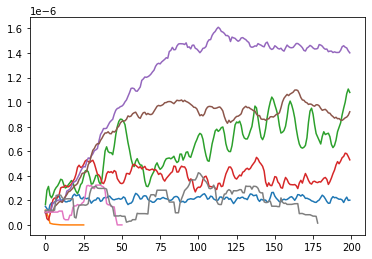

In [26]:
plt.plot(np.array([diff_esns_k_dist_clust_dict,
          diff_esns_k_dist_net_dict,
          diff_esns_k_fixed_clust_dict,
          diff_esns_k_fixed_net_dict,
          diff_ddns_k_dist_clust_dict,
          diff_ddns_k_dist_net_dict,
          diff_ddns_k_fixed_clust_dict,
          diff_ddns_k_fixed_net_dict,]).T)

(200, 2)
(200, 2)
(200, 2)
(200, 2)
(200, 2)
(200, 2)
(200, 2)
(200, 2)
(200, 2)
(200, 2)


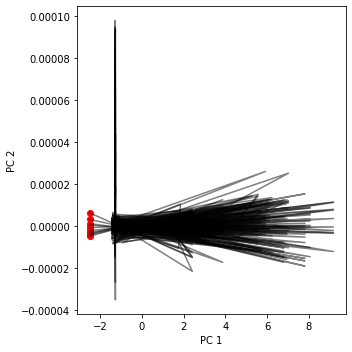

In [21]:
def plot_trajectories(data, n_components = 2,figsize = [5, 5],fig_out=None,c_start = 'red', c_end ='blue',alpha=0.1):
    
	assert n_components in [2,3], 'dimensions should be 2 or 3'
	
	pca = PCA(n_components=n_components)
	data = data
	pca_states = pca.fit_transform(data)
	print(pca_states.shape)
	if fig_out !=None:

		ax = fig_out
	else:
		fig = plt.figure(figsize=figsize,
				tight_layout=True,)
		if n_components>2:
			ax = fig.add_subplot(111,projection='3d')
		else:
			ax = fig.add_subplot(111,)
	# ax = Axes3D(fig)

	ax.set_xlabel('PC 1', fontweight=12)
	if n_components>2 :
		ax.set_zlabel('PC 3', fontweight=12)
	ax.set_ylabel('PC 2', fontweight=12)

	# For generating figure in paper.md
	# ax.set_xticks([-2, -1, 0, 1, 2])
	# ax.set_yticks([-1, 0, 1])
	# ax.set_zticks([-1, 0, 1])

	ax = plot_123d(ax,pca_states,**{'c':'black','alpha':0.5})
	if n_components>2 :
		ax.scatter(pca_states[0,0], pca_states[0,1], pca_states[0,2],  c=c_start, alpha=alpha)
		ax.scatter(pca_states[-1,0],pca_states[-1,1],pca_states[-1,2], c=c_end,   alpha=alpha)

	else:
		ax.scatter(pca_states[0,0], pca_states[0,1],  c=c_start, alpha=alpha)
		ax.scatter(pca_states[-1,0],pca_states[-1,1], c=c_end,  alpha=alpha)

%matplotlib inline 		
figsize = [5,5]

fig = plt.figure(figsize=figsize, tight_layout=True)
ax = fig.add_subplot(111,)
for i in range(len(ref_trajs)):
	plot_trajectories(np.array(ref_trajs[i])[:,:,0].T,fig_out=ax,c_start='green',alpha=1, c_end='pink',n_components=2)
	plot_trajectories(np.array(pert_trajs[i])[:,:,0].T,fig_out=ax,c_start='orange',alpha=1, c_end='red',n_components=2)

# plot_trajectories(h_new[0][:10,:,0], fig_out=ax)

plt.show()

# Visualize Networks

In [29]:
from simulator import NetworkSimulator

sim = NetworkSimulator(best_nets_ddns[1])
# sim.network.A = h[0][-1,:,:]
random_inputs =  np.random.uniform(0, 0.5, size=(100))

# sim.visualize(random_inputs)

<Axes: >

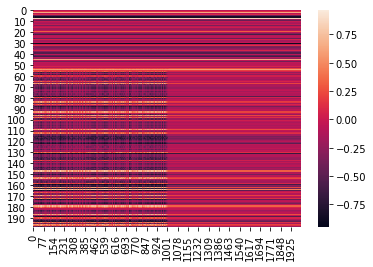

In [35]:
sns.heatmap(h[0][:,:,0].T)

# Get state matrix

<Axes: >

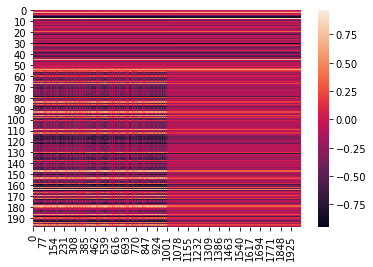

In [36]:
import seaborn as sns
from utils import createNARMA30

%matplotlib inline 
sim = NetworkSimulator(best_nets_ddns[1])
# random_inputs =INPUT[0]
net_states_ddn,states = sim.get_network_data(INPUT.T) # Note that first few samples will have transient dynamics
# net_states_ddn_zero = sim.get_network_data(np.zeros_like(random_inputs)) # Note that first few samples will have transient dynamics
# net_states_ddn_narma = sim.get_network_data(narma_input) # Note that first few samples will have transient dynamics

sns.heatmap(net_states_ddn)
# plt.show()


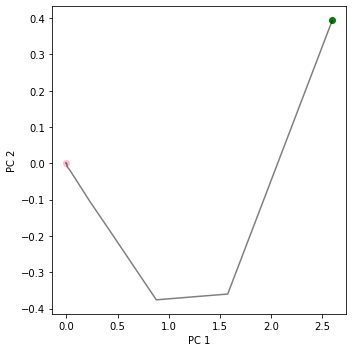

In [37]:
def plot_trajectories(data, n_components = 2,figsize = [5, 5],fig_out=None,c_start = 'red', c_end ='blue'):
    
	assert n_components in [2,3], 'dimensions should be 2 or 3'
	
	pca = PCA(n_components=n_components)
	data = data
	pca_states = pca.fit_transform(data)

	if fig_out !=None:

		ax = fig_out
	else:
		fig = plt.figure(figsize=figsize,
				tight_layout=True,)
		if n_components>2:
			ax = fig.add_subplot(111,projection='3d')
		else:
			ax = fig.add_subplot(111,)
	# ax = Axes3D(fig)

	ax.set_xlabel('PC 1', fontweight=12)
	if n_components>2 :
		ax.set_zlabel('PC 3', fontweight=12)
	ax.set_ylabel('PC 2', fontweight=12)

	# For generating figure in paper.md
	# ax.set_xticks([-2, -1, 0, 1, 2])
	# ax.set_yticks([-1, 0, 1])
	# ax.set_zticks([-1, 0, 1])

	ax = plot_123d(ax,pca_states,**{'c':'black','alpha':0.5})
	if n_components>2 :
		ax.scatter(pca_states[0,0], pca_states[0,1],pca_states[0,2], c=c_start ,alpha=1)
		ax.scatter(pca_states[-1,0],pca_states[-1,1],pca_states[-1,2], c=c_end,alpha=1)
	else:
		ax.scatter(pca_states[0,0], pca_states[0,1], c=c_start ,alpha=1)
		ax.scatter(pca_states[-1,0],pca_states[-1,1], c=c_end,alpha=1)

%matplotlib inline 		
figsize = [5,5]

fig = plt.figure(figsize=figsize, tight_layout=True)
ax = fig.add_subplot(111,)

plot_trajectories(h[0][1000:,:,0], fig_out=ax, c_start='green', c_end='pink')
# plot_trajectories(states[:,:,0], fig_out=ax)

plt.show()

In [26]:
import seaborn as sns
sim = NetworkSimulator(best_nets_esns[0])
random_inputs = np.random.normal(0, 0.5, size=(1000,))
net_states_esn = sim.get_network_data(random_inputs) # Note that first few samples will have transient dynamics
net_states_esn_zero= sim.get_network_data(np.zeros_like(random_inputs)) # Note that first few samples will have transient dynamics
net_states_esn_narma= sim.get_network_data(np.zeros_like(narma_input)) # Note that first few samples will have transient dynamics

sns.heatmap(net_states_esn)
plt.show()

NameError: name 'NetworkSimulator' is not defined

(199, 1000)

# Sampling different networks

In [14]:
from populations import FlexiblePopulation
# Pick your hyperparameter set
generation = 20
individual = 12
esn_hyperparameters_evolution = esn_dict['parameters']
ddn_hyperparameters_evolution = ddn_dict['parameters']
esn_hyperparams = esn_hyperparameters_evolution[generation][individual]
ddn_hyperparams = esn_hyperparameters_evolution[generation][individual]

# update/resample the networks
example_esn = best_nets_esns[5]
example_ddn = best_nets_ddns[5]

specific_esn = example_esn.get_new_network_from_serialized(esn_hyperparams)
specific_ddn = example_esn.get_new_network_from_serialized(ddn_hyperparams)

<Axes: >

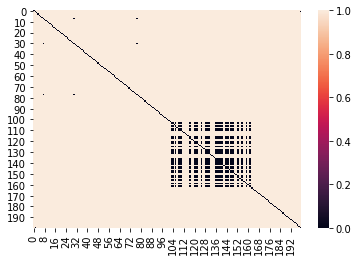

In [27]:
sns.heatmap(specific_ddn.D)

In [29]:

random_inputs = np.random.normal(0, 0.5, size=(1000,))
sim = NetworkSimulator(example_esn)

net_states_esn = sim.get_network_data(random_inputs) # Note that first few samples will have transient dynamics


In [49]:
from utils import *

# plt.plot()

# np.hstack()


(199, 2)

In [50]:
pca = PCA(n_components=2)

pca_states = pca.fit_transform(net_states_ddn)

# pca_states_zero = pca.fit_transform(net_states_ddn_narma)
pca_states_narma = pca.fit_transform(net_states_ddn_narma)

fig = plt.figure(figsize=(10, 10),
			tight_layout=True,)
ax = fig.add_subplot(111)
# ax = Axes3D(fig)

ax.set_xlabel('PC 1', fontweight=12)
# ax.set_zlabel('PC 3', fontweight=12)
ax.set_ylabel('PC 2', fontweight=12)

# For generating figure in paper.md
# ax.set_xticks([-2, -1, 0, 1, 2])
# ax.set_yticks([-1, 0, 1])
# ax.set_zticks([-1, 0, 1])

plot_123d(ax,pca_states[:,:],**{'c':'black','alpha':0.5})
plot_123d(ax,pca_states_zero[:,:],**{'c':'red','alpha':0.5})
plot_123d(ax,pca_states_narma[:,:],**{'c':'blue','alpha':0.5})

ax.scatter(pca_states[0, 0], pca_states[0, 1], c='red' ,alpha=1)
ax.scatter(pca_states[0,-1], pca_states[1,-1], c='blue',alpha=1)


ax.scatter(pca_states_zero[0, 0], pca_states_zero[0, 1], c='red' ,alpha=1)
ax.scatter(pca_states_zero[0,-1], pca_states_zero[1,-1], c='blue',alpha=1)


ax.scatter(pca_states_narma[0, 0], pca_states_narma[0, 1], c='red' ,alpha=1)
ax.scatter(pca_states_narma[0,-1], pca_states_narma[1,-1], c='blue',alpha=1)


NameError: name 'PCA' is not defined

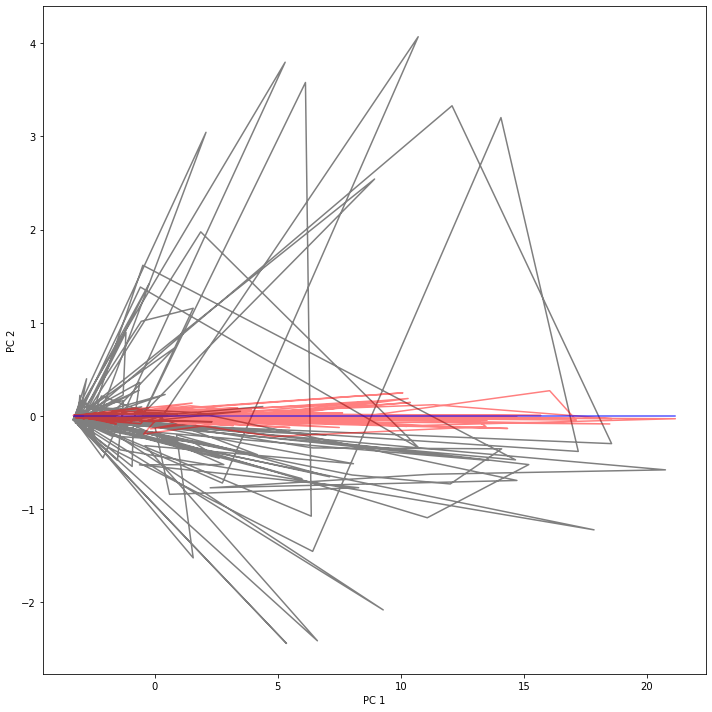

In [122]:
pca = PCA(n_components=2)

pca_states = pca.fit_transform(net_states_esn)

pca_states_zero = pca.fit_transform(net_states_esn_zero)
pca_states_narma = pca.fit_transform(net_states_esn_narma)


fig = plt.figure(figsize=(10, 10),
			tight_layout=True)
ax = fig.add_subplot(111)
# ax = Axes3D(fig)

ax.set_xlabel('PC 1', fontweight=12)
# ax.set_zlabel('PC 3', fontweight=12)
ax.set_ylabel('PC 2', fontweight=12)

# For generating figure in paper.md
# ax.set_xticks([-2, -1, 0, 1, 2])
# ax.set_yticks([-1, 0, 1])
# ax.set_zticks([-1, 0, 1])

plot_123d(ax,pca_states[:,:],**{'c':'black','alpha':0.5})
plot_123d(ax,pca_states_zero[:,:],**{'c':'red','alpha':0.5})
plot_123d(ax,pca_states_narma[:,:],**{'c':'blue','alpha':0.5})


## Fixed Point Analysis 